In [113]:
# ------------------ Clustering & ML ------------------
from sklearn.cluster import SpectralBiclustering
from scipy import stats

# ------------------ Core Libraries -------------------
import numpy as np
import pandas as pd
import math
import os
import warnings
import ast
from glob import glob

# ------------------ AnnData & Spatial Analysis -------
import scanpy as sc
import squidpy as sq
from anndata import AnnData
import geopandas as gpd

# ------------------ Geometry & Spatial --------------
from shapely.ops import unary_union
from shapely.geometry import Polygon as sPolygon
from matplotlib.patches import Polygon, Patch

# ------------------ Plotting -------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap, to_hex
import matplotlib.image as mpimg
import matplotlib as mpl

# ------------------ Image Handling -------------------
from PIL import Image
import cv2

# ------------------ Settings -------------------------
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None
%matplotlib inline
sc.settings.figdir = "../analysis/"
sc.settings.set_figure_params(facecolor='white')


## 🧠 Spatial Analysis Summary (Squidpy)

This analysis uses **Squidpy** to explore the spatial architecture of cell types in tissue sections. Below is a structured overview of the pipeline.
- Focus on **one specific** fov using local coordinates/**multiple fovs** using global coordinates
- Focus on **multiple fovs** using local coordinates

---

### ✅ Summary of Analysis Steps

| Step | Description |
|------|-------------|
| **1. Spatial Graph Construction** | Compute spatial neighbors using cell coordinates (`coord_type='generic'` for CosMx, `library_key='fov'` to separate FOVs) |
| **2. Neighborhood Enrichment** | Calculate Z-scores to assess how often clusters neighbor each other compared to random |
| **3. Co-occurrence Analysis** | Analyze the spatial co-occurrence of cell types across increasing distance bins |
| **4. Centrality Scores** | Quantify how central each cluster is using graph metrics (degree, closeness, clustering) |
| **5. Spatial Visualization** | Plot spatial scatter, co-occurrence curves, enrichment heatmaps, and more |
| **6. Multi-FOV Aggregation** | Compute spatial metrics per FOV, then aggregate across all FOVs (e.g., average Z-scores) |

---

### 📁 Outputs

- `spatial_neighbors`: Spatial graph stored in `adata.obsp["spatial_connectivities"]`
- `nhood_enrichment`: Z-score matrix in `adata.uns["leiden_nhood_enrichment"]["zscore"]`
- `co_occurrence`: Distance bin matrix in `adata.uns["leiden_co_occurrence"]["occ"]`
- `centrality_scores`: Centrality metrics in `adata.uns["leiden_centrality_scores"]`

---

### 📚 References

- 🔗 [Squidpy Documentation](https://squidpy.readthedocs.io/)
- 🔗 [Scanpy Documentation](https://scanpy.readthedocs.io/)
- 🧬 [CosMx Spatial Transcriptomics](https://nanostring.com)



In [115]:
# load data
data_read = '../raw/' # for raw data 
data_save = '../data/' # for processed data or intermediate result
analysis_save = '../analysis/' # for plots

adata = sc.read(data_save+'filtered_adata.h5ad')
cell_meta = pd.read_csv(data_save+'filtered_metadata_file.csv', index_col=0)
polygon_file = pd.read_csv(data_save+'filtered_polygons.csv', index_col=0)
coordinates = pd.read_csv(data_save+'filtered_coordinates.csv', index_col=0)
fov_id = [i for i in range(1,23) if i not in [3, 20]]

image = cv2.imread(data_read+"CellComposite/"+"CellComposite_F001.jpg", cv2.IMREAD_COLOR)
xlim_image = image.shape[1]
ylim_image = image.shape[0]

adata.obsm["spatial"] = adata.obsm["spatial"].values

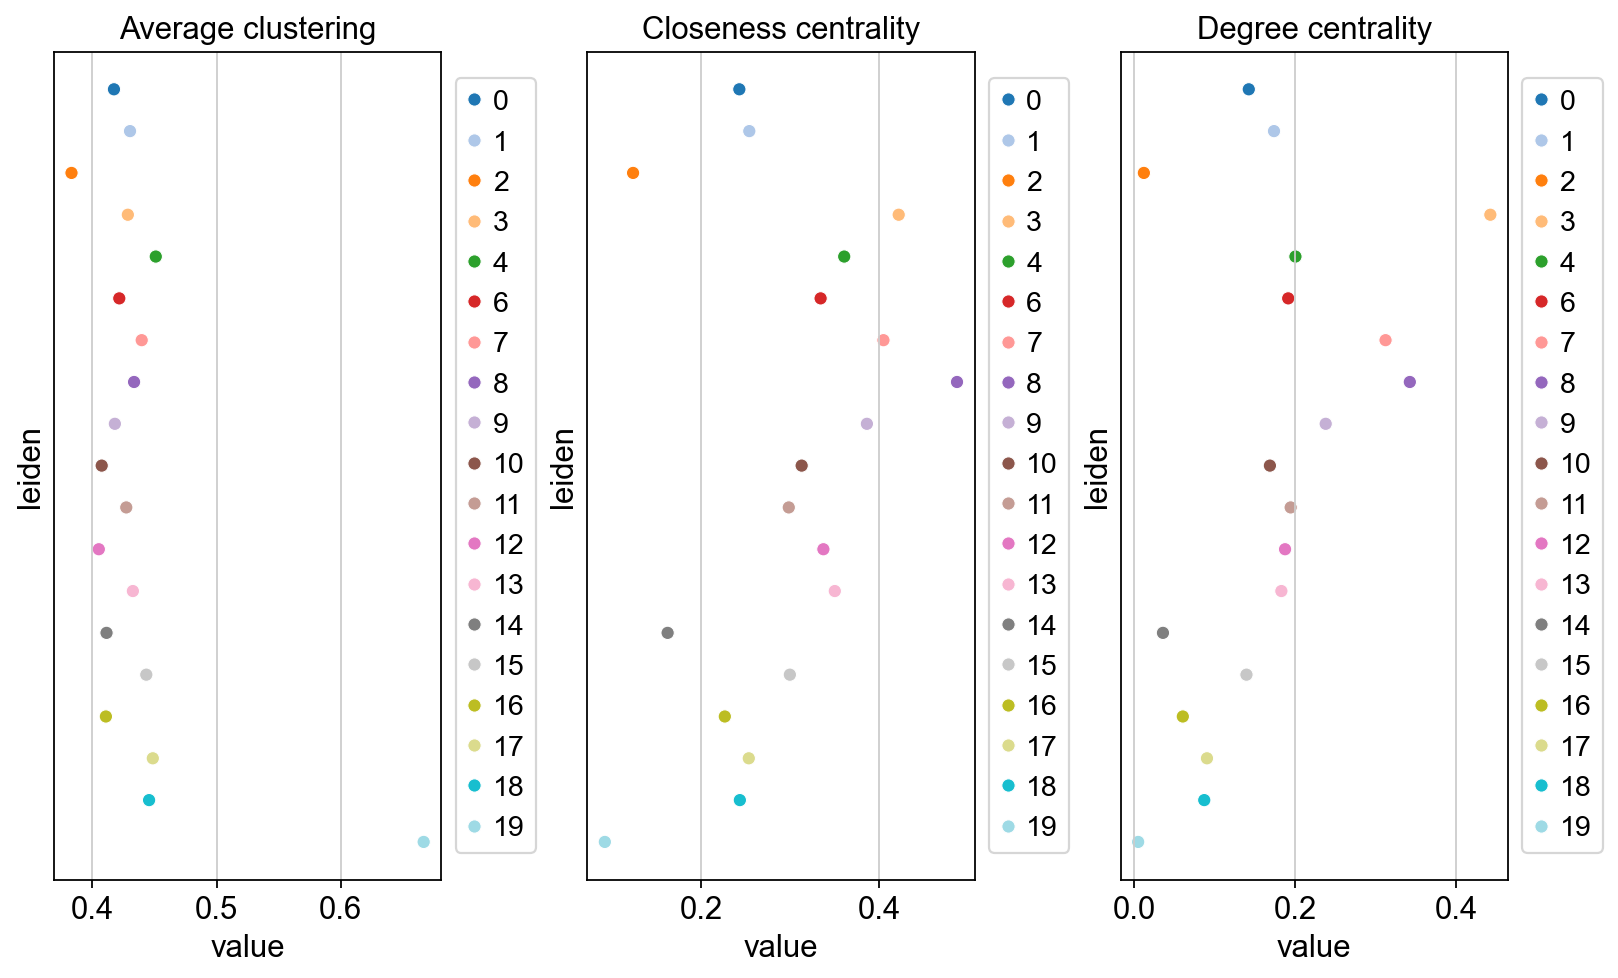

In [46]:
# focus on specific fov
fov = 16
group = 'leiden'
adata_sub = adata[adata.obs['fov'] == fov].copy()

## centrality scores
adata_spatial_neighbor = sq.gr.spatial_neighbors(
    adata_sub,
    n_neighs = 10,
    coord_type='generic',
    delaunay=True
)

sq.gr.centrality_scores(adata_sub, cluster_key=group)
sq.pl.centrality_scores(adata_sub, cluster_key=group, figsize=(10,6), save='_centrality_scores_leiden.png')
plt.savefig(analysis_save+"fov"+str(fov)+"_centrality_scores_"+group+".png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

  0%|          | 0/1 [00:00<?, ?/s]/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
100%|██████████| 1/1 [00:10<00:00, 10.56s/]


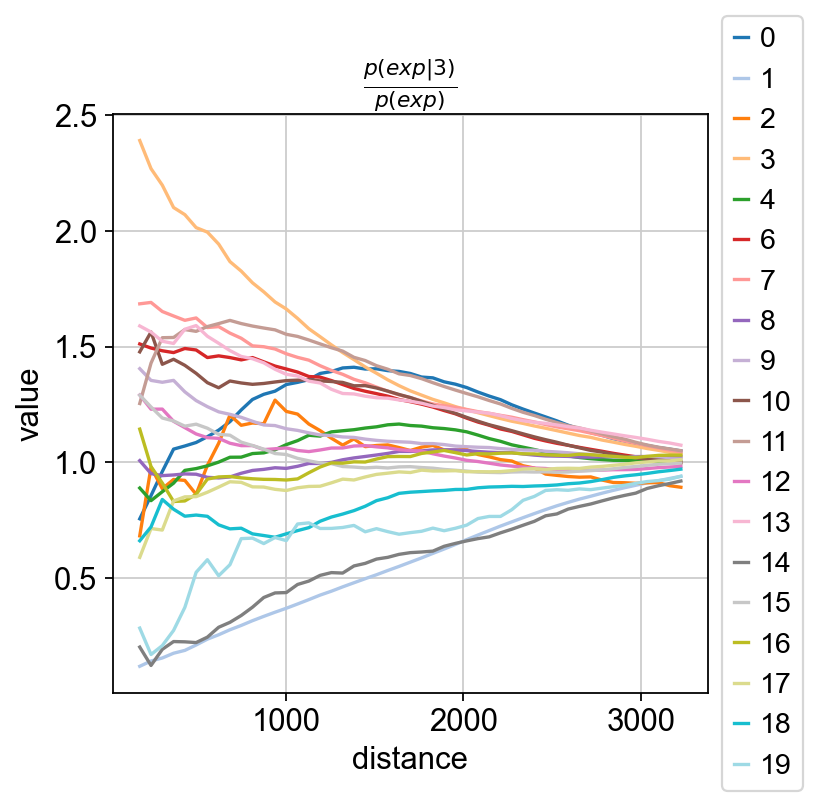

In [47]:
## co-occurence probability scores
cl = 3
sq.gr.co_occurrence(adata_sub, cluster_key=group)
sq.pl.co_occurrence(adata_sub, cluster_key=group, clusters=str(cl))
plt.savefig(analysis_save+"fov"+str(fov)+"_co_occurences_"+group+"_"+str(cl)+".png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

  0%|          | 0/1000 [00:00<?, ?/s]/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
100%|██████████| 1000/1000 [00:10<00:00, 97.78/s]


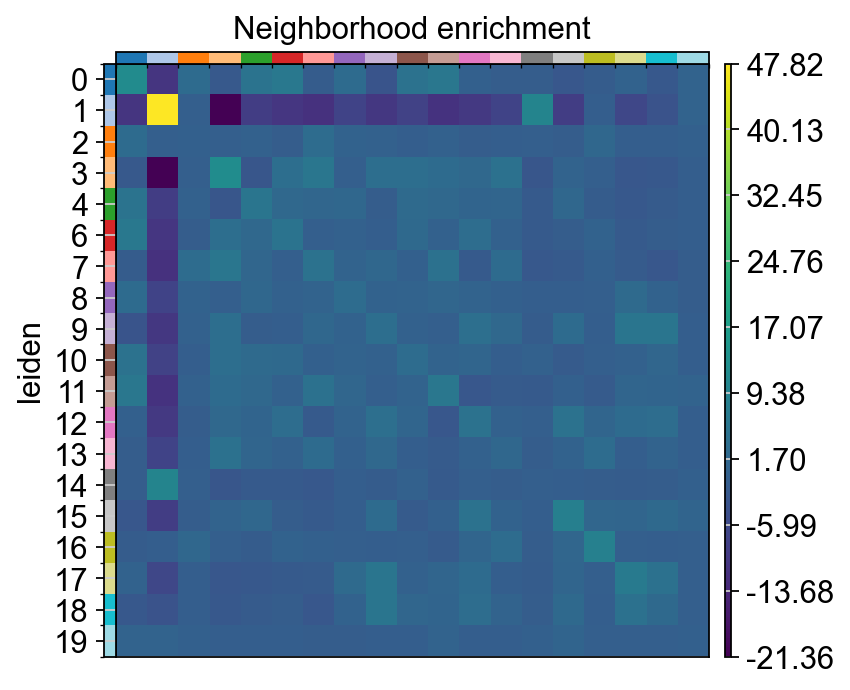

In [48]:
## Neiborhood enrichment analysis
sq.gr.nhood_enrichment(adata_sub, cluster_key=group)
sq.pl.nhood_enrichment(adata_sub, cluster_key=group,
                       figsize=(4,4))
plt.savefig(analysis_save+"fov"+str(fov)+"_nhood_enrichment_"+group+".png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


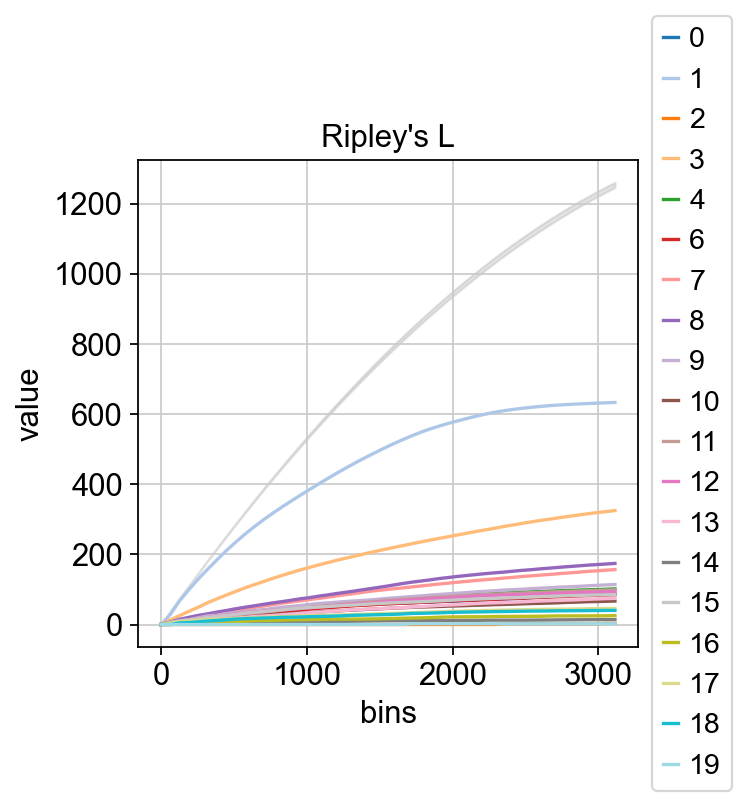

In [49]:
## Ripley's statistic
mode = "L"
sq.gr.ripley(adata_sub, cluster_key=group, mode=mode)
plt.savefig(analysis_save+"fov"+str(fov)+"_Ripley_"+group+"_"+mode+".png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [50]:
##  Moran's I value
sq.gr.spatial_autocorr(adata_sub,
                       mode='moran',
                       n_perms=100,
                       n_jobs=1)
adata_sub.uns['moranI'].to_csv(data_save+'fov'+str(fov)+'_MoranI.csv')

  0%|          | 0/100 [00:00<?, ?/s]/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
100%|██████████| 100/100 [00:16<00:00,  6.17/s]


1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
21
22
degree_centrality
average_clustering
closeness_centrality


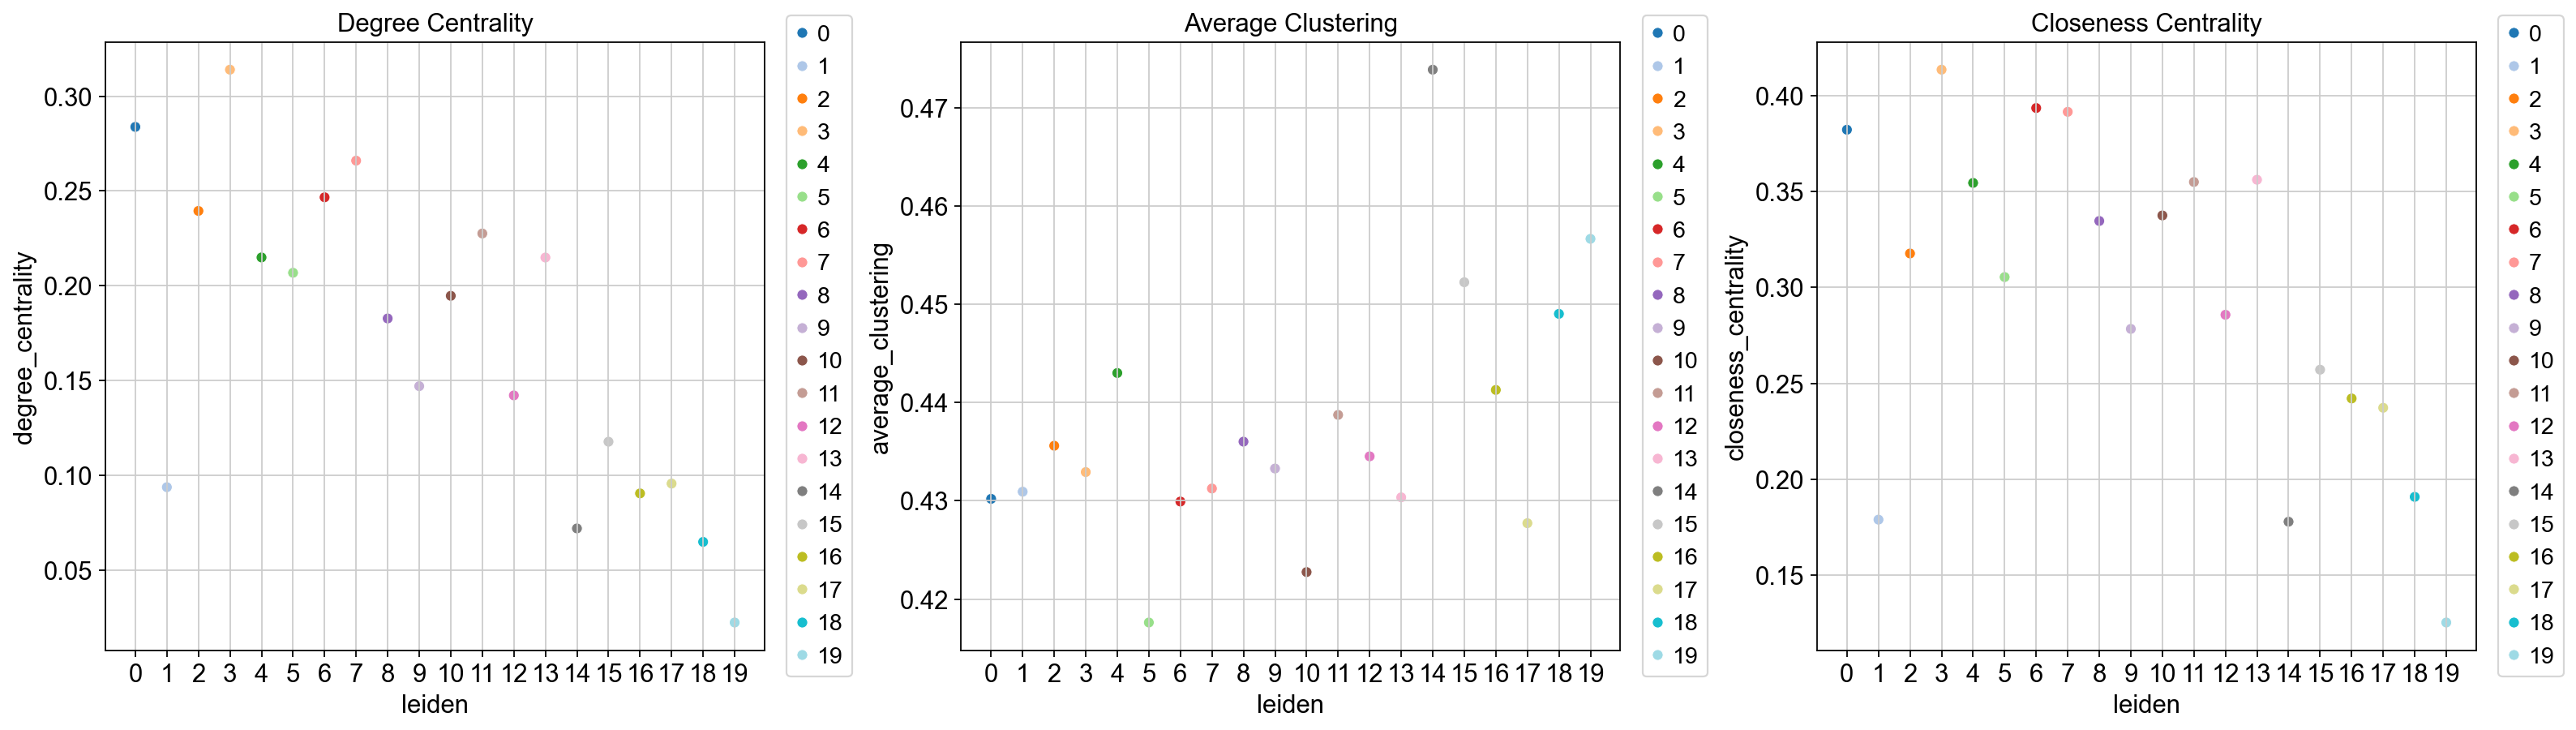

In [94]:
# focus on multiple fovs
group_level = adata.obs['leiden'].cat.categories.tolist()
group_color = {str(i):j for i,j in zip(group_level, sns.color_palette("tab20", len(group_level)))}

# centrality scores
fovs = [fov for fov in range(1,23) if fov not in [3,20]]
group = 'leiden'
cs_dict = pd.DataFrame(columns=['degree_centrality', 'average_clustering', 'closeness_centrality', 'leiden'])

for i in fovs:
    print(i)
    adata_sub = adata[adata.obs['fov'] == i].copy()

## centrality scores
    adata_spatial_neighbor = sq.gr.spatial_neighbors(
        adata_sub,
        n_neighs = 10,
        coord_type='generic',
        delaunay=True
    )
    sq.gr.centrality_scores(adata_sub, cluster_key=group)
    tmp = adata_sub.uns[group+"_centrality_scores"]
    tmp['leiden'] = adata_sub.uns[group+"_centrality_scores"].index.tolist()
    cs_dict = pd.concat([cs_dict,tmp],axis=0)
    
cs_dict = cs_dict.groupby('leiden').mean()
cs_dict['leiden'] = [str(i) for i in cs_dict.index.tolist()]
cs_dict['leiden'] = pd.Categorical(cs_dict['leiden'], categories=group_level, ordered=True)

fig, ax = plt.subplots(1,3, figsize=(20,6))
for i,j in enumerate(['degree_centrality', 'average_clustering', 'closeness_centrality']):
    print(j)
    sns.scatterplot(
        cs_dict,
        x='leiden',
        y=j,
        hue='leiden',
        palette = group_color,
        ax=ax[i]
    )
    ax[i].set_title(j.replace('_', ' ').title())
    ax[i].legend(
    loc='center right',            # align legend box to center-left
    bbox_to_anchor=(1.15, 0.5),  # (x_offset, y_offset) from axes
    )

plt.tight_layout()
plt.savefig(analysis_save+'multiple_fovs_centrality.png')
plt.show()

/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
100%|██████████| 91/91 [02:28<00:00,  1.63s/]


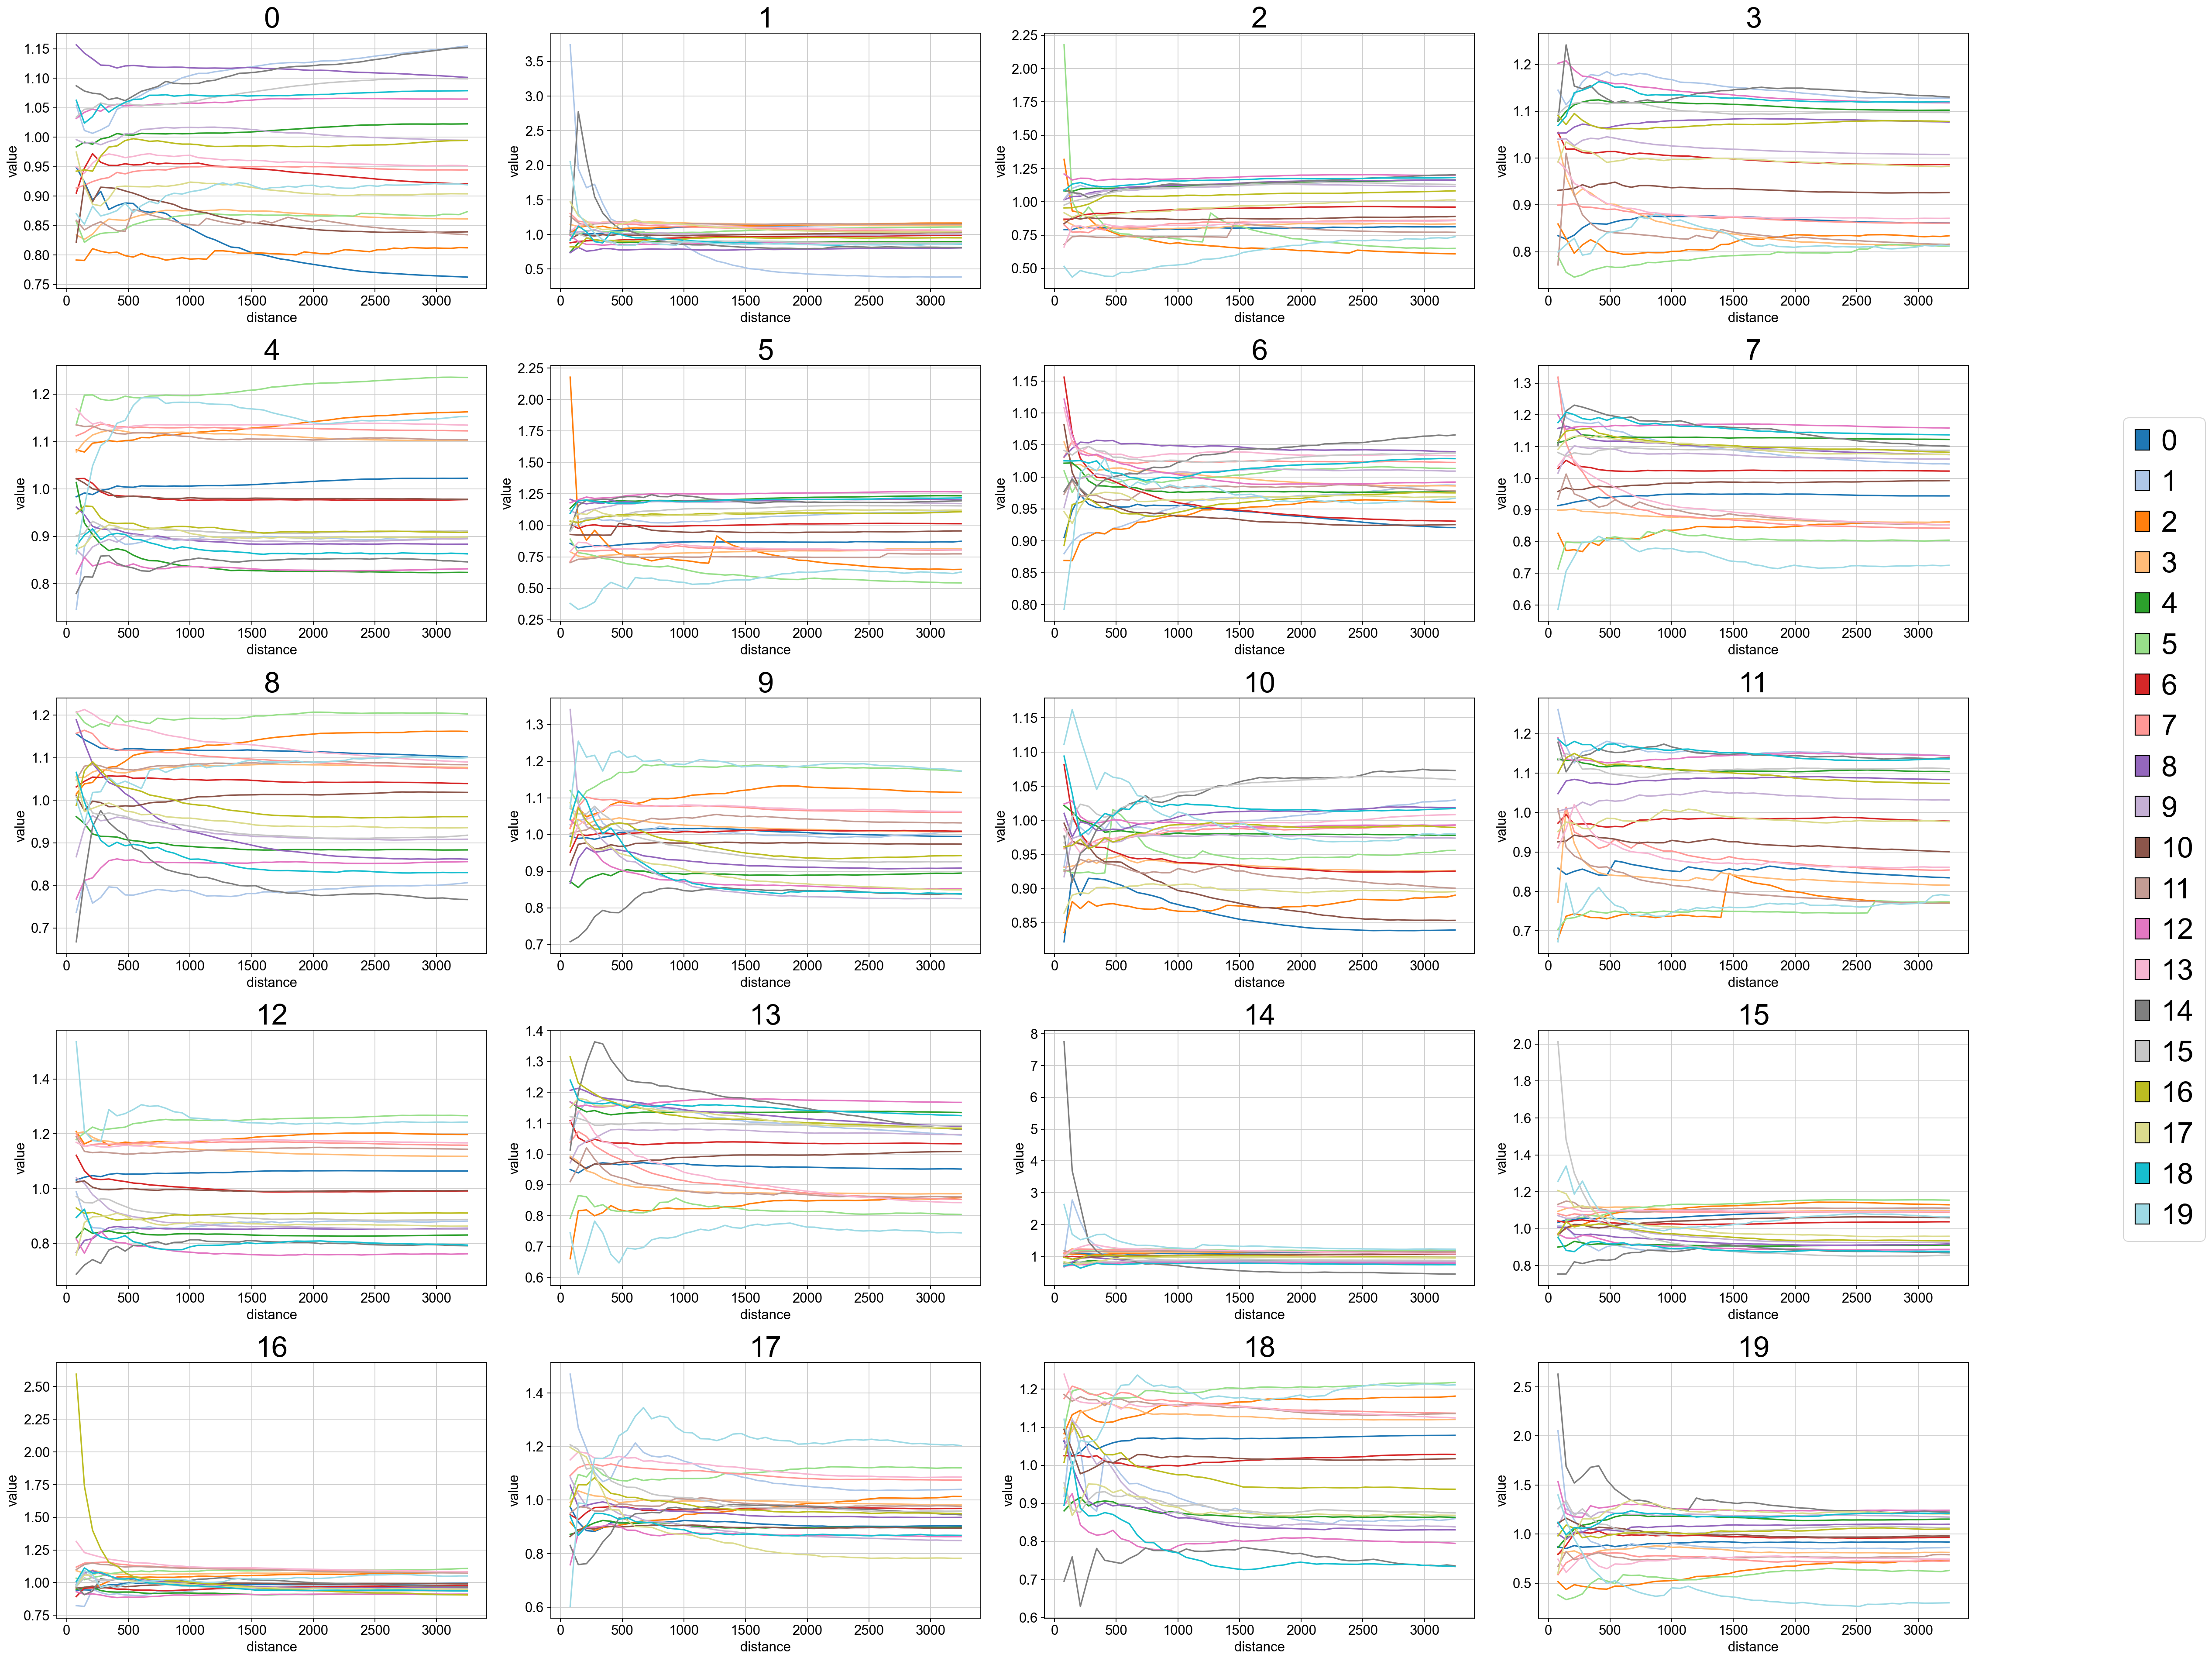

In [216]:
## co-occurence probability scores
sq.gr.spatial_neighbors(adata, coord_type="generic", library_key="fov", delaunay=True)
sq.gr.co_occurrence(adata, cluster_key=group)

img_col = 4
img_row = int(np.ceil(len(group_level)/img_col))

fig,axs = plt.subplots(img_row, img_col, figsize=(6*img_row, 6*img_col))
axs = axs.flatten()
for ax,i in enumerate(group_level):
    tmp = pd.DataFrame(adata.uns[group+'_co_occurrence']['occ'][ax,:,:], index=group_level, columns=adata.uns[group+'_co_occurrence']['interval'][1:].tolist())
    tmp['group'] = pd.Categorical(tmp.index.tolist(), categories=group_level, ordered=True)
    tmp = pd.melt(tmp, id_vars='group', var_name='distance', value_name='value')
    
    ax = axs[ax]
    
    sns.lineplot(
    data=tmp,
    x="distance",
    y="value",
    hue="group",
    hue_order=group_level,
    palette=group_color,
    ax=ax,
    legend=False
    )
    
    ax.set_title(i, fontsize=30)
    

# Create legend handles from group_color
handles = [
    Patch(facecolor=color, edgecolor='black', label=label)
    for label, color in group_color.items()
]

# Add custom legend to the figure
fig.legend(
    handles,
    [h.get_label() for h in handles],
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    fontsize=30,
    title=""
)
if len(group_level) < len(axs):
    for j in range(len(group_level), len(axs)):
        axs[j].axis('off')

plt.subplots_adjust(wspace=0.005, hspace=0.005)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.savefig(analysis_save+"multiple_fovs_co_occurences_"+group+".png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show() 


/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
100%|██████████| 1000/1000 [00:14<00:00, 66.80/s]


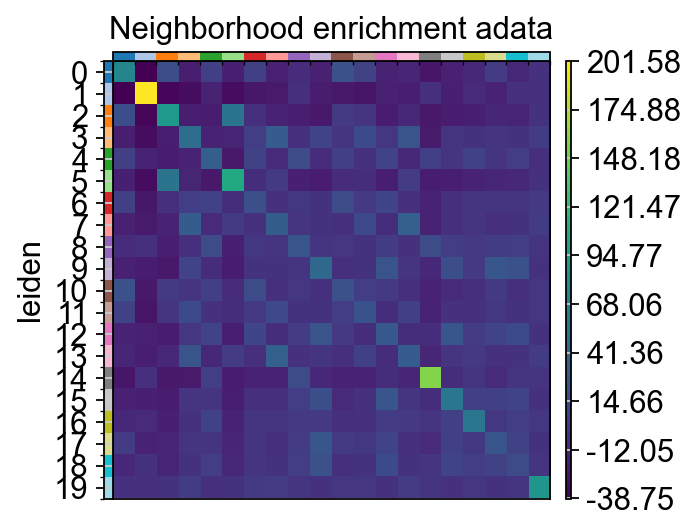

In [214]:
## Neiborhood enrichment analysis
sq.gr.spatial_neighbors(adata, coord_type="generic", library_key="fov",  delaunay=True)
sq.gr.nhood_enrichment(adata, cluster_key=group)
sq.pl.nhood_enrichment(
    adata,
    cluster_key=group,
    figsize=(3, 3),
    title="Neighborhood enrichment adata",
)
plt.savefig(analysis_save+"multiple_fovs_nNeighborhood_"+group+".png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

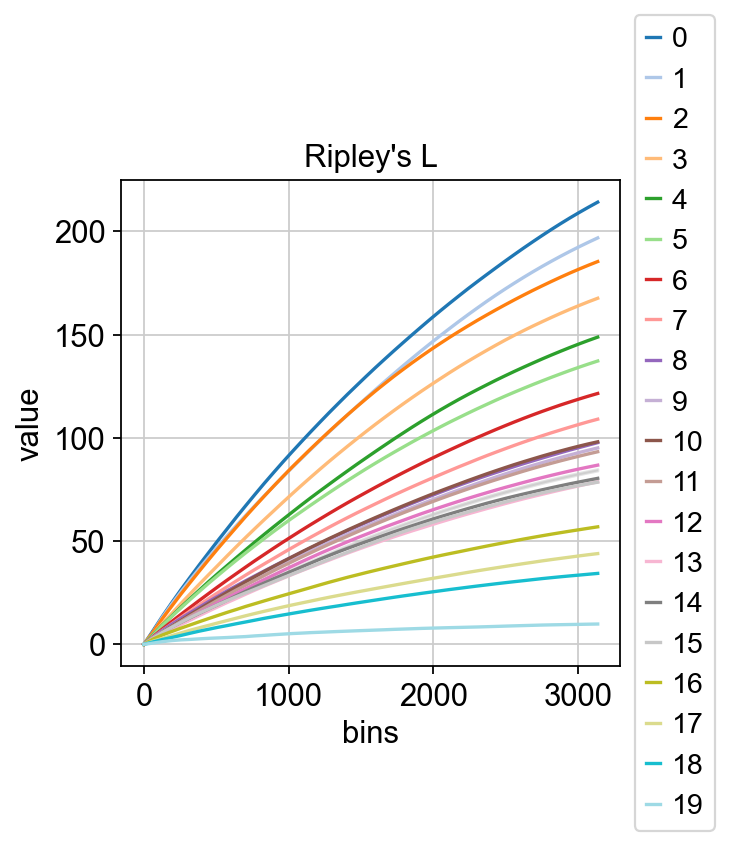

In [215]:
## Ripley's statistic
mode = "L"
sq.gr.spatial_neighbors(adata, coord_type="generic", library_key="fov",  delaunay=True)
sq.gr.ripley(adata, cluster_key=group, mode=mode)
sq.pl.ripley(
    adata,
    cluster_key=group,
    mode=mode
)
plt.savefig(analysis_save+"multiple_fovs_Ripley_"+mode+"_"+group+".png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()